<a href="https://colab.research.google.com/github/Zuzuztut/RayTracerCG/blob/tom/thetracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raytracer
Raytracer von Samuel Lang, Niklas Elsässer, Maurice Tonn und Tom Hofer
### Matrikelnummern
6664026, 4842156, 8111688, 4775319 
## Imports

In [1]:
import numpy as np
import numpy.typing as npt
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from PIL import Image
import time

Diese Funktion wird für die continuous_render Funktion benötigt. Sie ist lediglich dazu da die Ausgabe des Jupyter Notebooks zu aktualisieren.

In [3]:
from IPython.display import clear_output

### Parallelisierung

Zur Beschleunigung des Raytracers wurden der Camera Klasse die Funktionen _render_parallel und _render_segment hinzugefügt. Diese Teilen das Bild in Zeilen auf, die dann jeweils auf einer der verfügbaren CPUs berechnet werden. Die folgenden Softwarebibliotheken werden ausschließlich von diesen beiden Funktionen verwendet. Wir die PARALLEL Variable auf False gesetzt, dann werden diese Funktionen nicht verwendet. Die THREADS Variable legt die Anzahl an erstellten CPU Threads und damit die Anzahl an Segmenten in die das Bild unterteilt wird.

In [2]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed

PARALLEL = True
THREADS = multiprocessing.cpu_count()

## Vector Datentyp

Es wird als erstes ein Vektor Datentyp erstellt. Basierend auf diesem sind die Funktionen "normalize" und "lenght" implementiert.

Die Funktion "normalize" nimmt einen Vektor als Parameter und gibt den normalisierten Vektor zurück. Ein normalisierter Vektor hat die gleiche Richtung wie der ursprüngliche Vektor, aber eine Länge von 1.

Die Funktion "length" nimmt einen Vektor als Parameter und gibt die Länge des Vektors zurück.

In [4]:
vector = npt.NDArray[np.single]

def normalize(vec: vector):
    return vec/np.linalg.norm(vec)

def length(vec: vector):
    return np.sqrt(vec[0] ** 2 + vec[1] ** 2 + vec[2] ** 2)

## Ray Klasse
Die Klasse "Ray" repräsentiert einen (Licht) Strahl in einer Szene. Ein Strahl besteht aus einer Position (position), einer Richtung (direction) und einer Farbe (color).
Die Klasse hat einen Konstruktor, der die Position, die Richtung und die Farbe des Strahls als Vektoren speichert.
Die Klasse hat auch zwei Methoden: "at" und "reflect".

Die Methode "at" erwartet als Parameter eine Skalarzahl "x" und berechnet die Position eines Punkts entlang des Strahls, indem der Ursprung des Strahls um x in Richtung des direction Vektors verschoben wird.

Die Methode "reflect" erwartet als Parameter einen Vektor "axis", der die Normale des reflektierenden Objekts darstellt. Die Funktion berechnet die Richtung des reflektierten Strahls.

In [5]:
class Ray():
  def __init__(self, position: vector, direction: vector, color: vector):
    self.position = position
    self.direction = direction
    self.color = color

  def at(self, x):
    return self.position + x * self.direction

  def reflect(self, axis: vector):
    return self.direction - 2 * np.dot(self.direction, axis) * axis

## Material Klasse
Die Klasse "Material" ist eine abstrakte Klasse, die die Basis für alle Materialien in der Szene darstellt. Jedes 3D-Objekt in der Szene hat ein Material welches seine optischen Eigenschaften bestimmt.

Die Klasse enthält eine abstrakte Methode "reflectRay", die in jeder Unterklasse implementiert werden muss.

Die Methode "reflectRay" erwartet als Parameter einen Strahl (Ray), einen Treffpunkt (hit) und eine Normale (normal) und berechnet den an einer Oberfläche am Treffpunkt mit dem entsprechenden Material reflektierten Strahl.

Da jeder Typ von Material (z.B. emissives, reflektierendes, transparentes) anders berechnet werden muss, um zu bestimmen wie ein Strahl reflektiert wird, muss jede Unterklasse ihre eigene Implementierung der Methode "reflectRay" bereitstellen.

Diese Methode ist sehr wichtig für die Funktionsweise eines Raytracers, da sie es ermöglicht, die Auswirkungen von Materialien auf die Szene zu berechnen und zu rendern.

In [6]:
class Material(ABC):
  @abstractmethod
  def reflectRay(self, ray: Ray, hit: vector, normal: vector):
    pass

## Emissive Material Klasse
Die Klasse "Emissive" erbt von der Klasse "Material" und repräsentiert ein Material, das Licht ausstrahlt. Es wird verwendet, um Lichtquellen in einer Szene darzustellen.
Die Klasse hat einen Konstruktor, der einen Farbvektor "color" als Parameter akzeptiert. Dieser Farbvektor spezifiziert die Farbe des ausgestrahlten Lichts.
Die Klasse hat auch eine Methode "reflectRay" die als Parameter einen Strahl, einen Treffpunkt und eine Normale hat. Diese Methode berechnet wie der Strahl reflektiert wird, wenn er auf ein Objekt mit diesem Material trifft.
In diesem Fall gibt die Methode einen neuen Strahl zurück, dessen Ausgangspunkt und dessen Richtung eine Nullvektor sind, da Lichtquellen kein Licht reflektieren. Der Farbvektor des neuen Strahls ist gleich dem Farbvektor des einkommenden Strahls multipliziert mit dem Farbvektor des ausstrahlenden Materials.

Ein Strahl mit einem Nullvektor als richtung kann nicht mehr in die Szene gecastet werden. Das muss also später in der Render Funktion geprüft werden.

In [7]:
class Emissive(Material):
  def __init__(self, color: vector):
    self.color = color

  def reflectRay(self, ray: Ray, hit: vector, normal: vector):
    return Ray(np.array([0,0,0]), np.array([0,0,0]), ray.color * self.color)

## Opaque Material Klasse
Die Klasse "Opaque" erbt von der abstrakten Klasse "Material" und repräsentiert ein undurchsichtiges Material, das Licht reflektiert und absorbiert. Wir implementieren in unserem Materialmodell zwei Arten der Reflektion, diffuse Refektion und specular Reflektion. Bei diffuser Reflektion geht der reflektierte Strahl in eine zufällige Richtung, wohingegen bei specular Reflektion der Ausfallswinkel ähnlich dem Einfallswinkel ist. Der Anteil an diffus und specular Reflektiertem Licht wird durch den Parameter shininess festgelegt. Dieser hat einen Wertebereich von 0.0 bis 1.0., wobei ein Wert von 0.0 für vollständig diffuse und ein Wert von 1.0 für vollständig speculare Reflection steht. Die shininess ist ein Parameter der angibt, wie nah der Ausfallswinkel dem Einfallswinkel kommen soll. Die shininess ist ein Wert größer Null und nähert sich für große Werte der perfekten Reflektion, wodurch eine spiegelnde Oberfläche erreicht werden kann. (Eine spiegelde Oberfläche hat zusätzlich eine shininess von 1.0). Die Berechnung des an einer Oberfläche des entsprechenden Materials reflektierten Rays erfolgt in der "reflectRay" Funktion.

Die Farbe des reflektierten Strahls wird dann berechnet indem die Farbe des einfallenden Strahls, je nach Art der Reflektion, mit dem diffusen oder secular Farbvektor des Materials multipliziert wird.
Das Ergebnis ist ein neues Ray-Objekt mit den berechneten Position, Richtung und Farbe und dieses wird zurückgegeben.
Diese Methode simuliert die Art und Weise, wie Licht von undurchsichtigen Materialien in der Realität reflektiert wird und trägt so zur Erhöhung des Realismus der Szene bei. Durch die Zufälligkeit in der Berechnung der Richtung des reflektierten Strahls wird auch die Unregelmäßigkeit der Oberflächen simuliert.

In [8]:
class Opaque(Material):
  def __init__(self, diffuse: vector, specular: vector,
               shininess: float, smoothness: float):
    self.diffuse = diffuse
    self.specular = specular
    self.shininess = shininess
    self.smoothness = smoothness

  def reflectRay(self, ray: Ray, hit: vector, normal: vector):
    if self.shininess < np.random.rand(): # diffuse
      direction =  np.random.randn(3)
      if np.dot(direction, normal) > 0: # make sure ray does not cross the surface
        direction = direction * -1
      color = ray.color * self.diffuse
    else: # specular
      direction = ray.reflect(normal) + np.random.rand(3) / self.smoothness
      if np.dot(direction, normal) > 0: # make sure ray does not cross the surface
        direction = direction * -1
      color = ray.color * self.specular
    return Ray(hit, normalize(direction), color)

## Object Klasse
Die Klasse "Object" ist eine abstrakte Klasse, die die Basis für alle 3D-Objekte in der Szene darstellt. Sie enthält eine abstrakte Methode "hit", die in jeder Unterklasse implementiert werden muss.

Die Methode "hit" erwartet als Parameter einen Strahl (Ray) und berechnet, ob dieser Strahl das Objekt trifft und falls ja, wo er trifft. Sie gibt dann ein "Hit"-Objekt zurück, das die Distanz zwischen dem Ausgangspunkt des Strahls und dem Treffpunkt, die Normale des Objekts an der Stelle des Treffpunkts und das Material des Objekts enthält. Die Hit Klasse wird im Folgenden implementiert.
Da jeder Typ von 3D-Objekt (z.B. Kugel, Kasten, etc.) anders berechnet werden muss, um zu bestimmen, ob ein Strahl es trifft und wo, muss jede Unterklasse ihre eigene Implementation der Methode "hit" bereitstellen.

Diese Methode ist sehr wichtig für die Funktionsweise eines Raytracers, da es die Möglichkeit gibt, ob ein Strahl ein Objekt trifft und wo er trifft, und diese Informationen werden später verwendet um die Szene zu berechnen und zu rendern.

In [9]:
class Object():
  @abstractmethod
  def hit(self, ray: Ray):
    pass

## Hit Klasse
Das Hit Objekt wird als Rückgabewert der hit Funktion von Objekten verwendet. Es enthält informationen über das getroffene Objekt.
Die Klasse "Hit" repräsentiert einen Treffer in einer Szene, wenn ein Strahl (Ray) auf ein Objekt trifft. In einem Raytracer werden Strahlen verwendet, um die Szene zu rendern, indem sie von der Kamera ausgesendet und mit den Objekten in der Szene interagieren.
Die Klasse enthält drei Attribute:

  - "distance" speichert die Distanz zwischen dem Ausgangspunkt des Strahls und dem Treffpunkt auf dem Objekt.
  - "normal" speichert die Normale des Objekts an der Stelle des Treffpunkts. Die Normale ist ein Vektor, der senkrecht auf der Oberfläche des Objekts steht und wichtig für die Berechnung von Schattierungen und Reflektionen ist.
  - "material" speichert das Material des Objekts, auf das der Strahl trifft. Dies enthält Informationen wie Farbe, Reflexion und Transparenz, die für die weitere Berechnung der Szene verwendet werden.
  
Die Klasse "Hit" wird als Rückgabewert der hit Funktionen von Objekten verwendet. Sie enthält die notwendigen Informationen für die Render Funktion zum weiteren rendern der Szene.

In [10]:
class Hit():
  def __init__(self, distance: float, normal: vector, material: Material):
    self.distance = distance
    self.normal = normal
    self.material = material

## Sphere Klasse
Die Klasse "Sphere" erbt von der abstrakten Klasse "Object" und repräsentiert eine Kugel in einer Szene. Eine Kugel hat eine Position (position), einen Radius (radius) und ein Material (material).
Die Klasse hat einen Konstruktor, der die Position, den Radius und das Material der Kugel als Vektoren bzw. Skalarzahlen speichert.

Die Klasse hat auch eine Methode "hit", die berechnet, ob ein Strahl die Kugel trifft und, falls ja, wo und mit welcher Normale. Die Methode erwartet ein Ray-Objekt als Parameter.

Die Methode berechnet zunächst die Koeffizienten b und c der quadratischen Gleichung, die durch den Strahl und die Kugel definiert ist. Anschließend berechnet sie die Determinante d, den Wert unter dem Wurzelzeichen in der quadratischen Formel. Wenn d größer als Null ist, dann hat der Strahl die Kugel getroffen und die Methode berechnet die beiden Lösungen(hit1,hit2) der quadratischen Gleichung. Wenn beide Lösungen größer als Null sind, dann wählt die Methode die kleinste als die tatsächliche Trefferstelle, da sich diese Näher am Ursprung des Strahls befindet und damit zuerst getroffen wird.
Es wird ein Hit-Objekt erzeugt welches die Entfernung (distance), die Normale (normal) an der Stelle des Treffers und das Material (material) der Kugel enthält und zurückgibt.
Durch eine Überprüfung ob beide Schnittpunkte des Strahls mit der Kugel positiv sind, stellen wir sicher, dass die Kugel nicht hinter der Kamera ist, oder sich die Kamera in der Kugel befindet.
Dieses Hit-Objekt wird später verwendet, um die Farbe des reflektierten Strahls zu berechnen und um die Szene zu rendern.
Wenn d kleiner oder gleich Null ist, dann hat der Strahl die Kugel nicht getroffen und die Methode gibt "None" zurück.

Diese Methode ermöglicht es uns, zu bestimmen, ob ein Strahl eine Kugel in der Szene trifft und wo und mit welcher Normale. Es ist ein wichtiger Bestandteil des Raytracing-Algorithmus, da es ermöglicht, die Art und Weise zu berechnen, wie Licht von einer Kugel reflektiert wird.

Die Sphere Klasse wird in der Finalen Szene nicht eingesetzt, wurde jedoch zum testen des Raytracers in früheren Entwicklungsständen verwendet, da Kugeln wesentlich einfacher zu implemetieren sind als zum Beispiel Dreiecke.

In [439]:
class Sphere(Object):
  def __init__(self, position: vector, radius: float, material: Material):
    self.position = position
    self.radius = radius
    self.material = material
  
  def hit(self, ray: Ray):
    b = 2 * np.dot(ray.direction, ray.position - self.position)
    c = np.linalg.norm(ray.position - self.position) ** 2 - self.radius ** 2
    d = b ** 2 - 4 * c
    if d > 0:
      hit1 = (-b + np.sqrt(d)) / 2
      hit2 = (-b - np.sqrt(d)) / 2
      if hit1 > 0 and hit2 > 0:
        hit = min(hit1, hit2)
        return Hit(hit, normalize(self.position - ray.at(hit)), self.material)
    return None

## Triangle Klasse
Die Klasse "Triangle" erbt ebenfalls von der abstrakten Klasse "Object" und repräsentiert ein Dreieck in einer Szene. Ein Dreieck hat drei Eckpunkte (a, b, c) und ein Material (material).
Die Klasse hat einen Konstruktor, der die Eckpunkte und das Material als Vektoren speichert und die Normale (normal) des Dreiecks berechnet, indem er die Kreuzprodukt von den Vektoren ab-a und c-a berechnet und normalisiert.
Die Klasse hat auch eine Methode "hit", die berechnet, ob ein Strahl das Dreieck trifft und, falls ja, wo und mit welcher Normale. Die Methode erwartet ein Ray-Objekt als Parameter.

Die Methode berechnet zunächst das Dot-Produkt aus der Richtung des Strahls und der Normale des Dreiecks. Wenn dieser Wert gleich Null ist, dann trifft der Strahl das Dreieck nicht und die Methode gibt "None" zurück.
Ansonsten berechnet die Methode den Wert der Entfernung (hit) des Treffpunkts auf dem Strahl durch das Dot-Produkt von der Position des Strahls und der Normale des Dreiecks und teilt es durch d.
Danach berechnet die Methode den Punkt (p) auf dem Strahl, der die Entfernung (hit) von der Position des Strahls entfernt ist.
Es werden dann 3 Dot-Produkte von den Kreuzprodukten der Vektoren b-a, c-b, a-c und p-a,p-b,p-c berechnet. Wenn mindestens eins von diesen Dot-Produkten kleiner gleich Null ist, dann bedeutet es das der Punkt p nicht innerhalb des Dreiecks liegt und die Methode gibt "None" zurück, andernfalls wird ein Hit-Objekt erstellt und zurückgegeben. 

Diese Methode ermöglicht es uns, zu bestimmen, ob ein Strahl ein Dreieck in der Szene trifft und wo und mit welcher Normale. Sie ist ein wichtiger Bestandteil des Raytracing-Algorithmus, da sie ermöglicht, die Art und Weise zu berechnen, wie Licht von einem Dreieck reflektiert wird.
Es wird überprüft ob der Strahl das Dreieck schneidet und ob die Berechnungen innerhalb des Dreiecks liegen und gibt entsprechende Informationen zurück.

Mithilfe von Dreiecken kann jedes beliebige dreidimensionale Modell konstruiert werden.

In [12]:
class Triangle(Object):
  def __init__(self, a: vector, b: vector, c: vector, material: Material):
    self.a = a
    self.b = b
    self.c = c
    self.material = material
    self.normal = normalize(np.cross(b-a, c-a))

  def hit(self, ray: Ray):
    d = np.dot(ray.direction, self.normal)
    if d == 0:
      return None
    hit = np.dot(self.a - ray.position, self.normal) / d
    p = ray.at(hit)
    if np.dot(np.cross(self.b - self.a, p - self.a), self.normal) <= 0: 
        return None
    if np.dot(np.cross(self.c - self.b, p - self.b), self.normal) <= 0: 
        return None
    if np.dot(np.cross(self.a - self.c, p - self.c), self.normal) <= 0:
        return None
    return Hit(hit, self.normal, self.material)


## Hilfsfunktion zum Erstellen einer Box aus Dreiecken
Diese Funktion erstellt eine Box anhand von 8 Eckpunkten (a, b, c, d, e, f, g, h) und einem Material. Die Funktion erstellt 12 Dreiecke, die zusammen die Box ergeben, und gibt sie als Array zurück. Die Funktion erstellt die Dreiecke, die die Oberseite, die linke Seite, die Rückseite, die Unterseite, die rechte Seite und die Vorderseite der Box bilden.
Das Material wird an jedes Dreieck übergeben und jedes Dreieck wird in den Array gespeichert. Dieser Array wird dann verwendet um die Box der Szene hinzuzufügen und das Licht auf ihr zu berechnen.

In [13]:
def get_box(a, b, c, d, e, f, g , h, material):
    return np.array([
        # Top
        Triangle(a, b, c, material),
        Triangle(a, b, d, material),
        # left
        Triangle(a, e, f, material),
        Triangle(a, f, b, material),
        # back
        Triangle(a, d, h, material),
        Triangle(a, h, e, material),
        # bottom
        Triangle(e, f, g, material),
        Triangle(e, g, h, material),
        # right
        Triangle(c, g, h, material),
        Triangle(c, h, d, material),
        # front
        Triangle(b, f, g, material),
        Triangle(b, g, c, material)])

## Scene Klasse
Die Klasse "Scene" repräsentiert eine 3D-Szene, in der Objekte und Lichtquellen platziert werden können.

Die Klasse enthält die Liste: "objects". Die Liste "objects" speichert alle Objekte, die in der Szene platziert sind.

Die Klasse enthält die Methode: "add". Diese fügt ein Objekt der Liste "objects" hinzu. 

In [14]:
class Scene():
  def __init__(self):
    self.objects = []
    
  def add(self, obj: Object):
    self.objects.append(obj)

## Camera Klasse
Die Klasse Camera repräsentiert eine Kamera. Die Klasse hat mehrere Methoden und Attribute, die verwendet werden, um das Bild zu rendern.

In der \_\_init\_\_ Methode werden einige Attribute initialisiert, wie die Position und Richtung der Kamera, die Up-Richtung, das Sichtfeld (FOV), die Größe des Bildes in x- und y-Richtung, die Anzahl der Reflektionen (bounces), die Anzahl der Iterationen und die Farbe des Himmels.

Die Methode _getRay erzeugt einen Lichtstrahl, der von der Kamera ausgeht und in Richtung eines bestimmten Pixels im Bild geht. Dazu wird die Position des Pixels (x,y) berechnet, indem die Position der Kamera, die Richtung und die Position relativ zur Mitte des Bildes (in Pixeln) berücksichtigt werden.

Die Methode _getClosestHit bestimmt das nächste Objekt, welches von dem Lichtstrahl getroffen wird. Dazu werden alle Objekte in der Szene durchiteriert und für jedes Objekt wird überprüft ob der Lichtstrahl das Objekt trifft. Falls das Objekt getroffen wird, wird die Distanz zum Treffpunkt berechnet und gespeichert. Am Ende wird das Objekt mit der kürzesten Distanz zurückgegeben. Um sicherzustellen, dass nicht versehentlich eine Oberfläche zwei mal getroffen wird, muss die Distanz größer als 0,0001 sein.

Die Methode _castRay führt das eigentliche Raytracing durch. Dazu wird der Lichtstrahl mit der Methode _getClosestHit auf das nächste Objekt gerichtet und die Farbe des Lichtstrahls an dieser Stelle berechnet. Dazu wird die Methode reflectRay des Materials des getroffenen Objekts aufgerufen. Falls der Lichtstrahl auf eine Lichtquelle trifft, wird die Farbe des Lichtstrahls direkt zurückgegeben. Erkannt wird das dadurch das der Ray einen Nullvektor als Richtungsvektor hat. Ansonsten wird die Methode rekursiv aufgerufen und der nächste Treffpunkt berechnet. Falls die maximale Reflektionstiefe erreicht ist, wird die Farbe des Strahls mit sky multipliziert und zurückgegeben.

Die Methode render ruft die Methode _castRay für jeden Pixel im Bild mehrere Male auf und speichert das Ergebnis in einem Bild-Array. Dies kann entweder sequentiell oder parallel durchgeführt werden. Am Ende wird das Bild normalisiert und zurückgegeben.

Die render_continuous Funktion kann alternativ zur render Funktion aufgerufen werden. Dabei wird der Algorithmus wiederholt aufgerufen und das Bild so kontinuierlich verbessert. Zusätzlich wird nach jedem Zyklus der Array mit den Rohdaten des Bilds in einer .npy Datei gespeichert. Dadurch kann der Raytracer parallel auf mehreren Rechnern ausgeführt werden. Die einzelnen Arrays können dann wieder geladen und zusammengeführt werden.

Die _render_parallel Methode wird in der render Funktion aufgerufen falls die PARALLEL Variable auf True gesetzt wurde. Die Methode erstellt THREAD (Variable) Threads, die die Funktion _render_segment ausführen. Das Bild wird in THREAD Zeilen unterteilt, jeder Thread berechnet dann eine Zeile des Bildes.

Die _render_segment Funktion ähnelt der render Funktion, berechnet jedoch nur einen Ausschnitt und nicht das gesamte Bild.

In [15]:
class Camera():
  def __init__(self, position: vector, direction: vector, up: vector,
               fov: float, size_x: np.uint, size_y: np.uint,
               bounces: np.uint, iterations: np.uint, sky: vector):
    self.position = position
    self.direction = normalize(direction)
    self.up = normalize(up)
    self.left = normalize(np.cross(self.direction, self.up))
    self.fov = fov
    self.pixelSize = - np.tan(fov * np.pi / 180 / 2.0) * 2.0 / size_x
    self.size_x = size_x
    self.size_y = size_y
    self.bounces = bounces
    self.iterations = iterations
    self.sky = sky
    self.img = np.zeros((self.size_y, self.size_x, 3))
  
  def _getRay(self, x, y):
    pixelPosition = self.position + self.direction \
    + self.left * (x - self.size_x / 2 + (np.random.randint(100) - 50 ) / 50) * self.pixelSize \
    + self.up * (y - self.size_y / 2 + (np.random.randint(100) - 50) / 50) * self.pixelSize
    rayDirection = normalize(pixelPosition - self.position)
    return Ray(self.position, rayDirection, np.array([1,1,1]))

  def _getClosestHit(self, ray: Ray, scene: Scene):
    closestHit = None
    for obj in scene.objects:
      hit = obj.hit(ray)
      if hit is not None:
        if hit.distance > 0.0001: # catch degenerate scatter direction
          if closestHit is None:
            closestHit = hit
          elif hit.distance < closestHit.distance:
            closestHit = hit
    return closestHit

  def _castRay(self, ray: Ray, scene: Scene):
    for b in range(self.bounces):
      closestHit = self._getClosestHit(ray, scene)
      if closestHit is None:
        return ray.color * self.sky
      ray = closestHit.material.reflectRay(ray, ray.at(closestHit.distance),
                                          closestHit.normal)
      if ray.direction.all() == 0: # light source hit
        return ray.color
    return np.array([0,0,0])

  def render(self, scene: Scene):
    if PARALLEL:
      self._render_parallel(scene)
    else:
      for y in range(self.size_y):
        for x in range(self.size_x):
          for i in range(self.iterations):
            self.img[y, x] += self._castRay(self._getRay(x, y), scene)
    return np.power(self.img/np.max(self.img), 0.45)

############################ continuous rendering ########################################

  def render_continuous(self, scene: Scene):
    try: 
      plt.figure()
      iteration = 0
      img = self.img
      runID = np.random.randint(999999)
      while(True):
        iteration += self.iterations
        img = self.render(scene)
        plt.imshow(img)
        plt.title('Iteration: %d' % iteration)
        plt.show()
        clear_output(wait=True)
        with open(str(runID) + '_' + str(self.size_x) + 'x' + str(self.size_y) + '_' + str(iteration) + '.npy', 'wb') as f:
          np.save(f, self.img)
    except KeyboardInterrupt:
      plt.imshow(img)
      print("Stopped Rendering!!")

    
############################ parallel rendering ##########################################

  def _render_segment(self, scene: Scene, img, segment_size: np.uint, offset: np.uint, results: list, segment_idx: np.uint):
      np.random.seed(int(time.time())) # ensure randomness in multiprocessing
      for y in range(segment_size):
        for x in range(self.size_x):
          for i in range(self.iterations):
            img[y, x] += self._castRay(self._getRay(x, y + offset), scene)
      results[segment_idx] = img
      return results
    

  def _render_parallel(self, scene: Scene):
    processes = []
    manager = multiprocessing.Manager()
    results = manager.dict()

    rest = int(self.size_y % THREADS)
    segment_size = int((self.size_y - rest) / THREADS)
    for i in range(THREADS):
      offset = i * segment_size
      if i < THREADS - 1:
        img = np.zeros((segment_size, self.size_x, 3))
        processes.append(multiprocessing.Process(target=self._render_segment, args=(scene, img, segment_size, offset, results, i)))
        processes[-1].start()
      else: 
        img = np.zeros((segment_size + rest, self.size_x, 3))
        processes.append(multiprocessing.Process(target=self._render_segment, args=(scene, img, segment_size + rest, offset, results, i)))
        processes[-1].start()
    for i in range(len(processes)):
        processes[i].join()

    for i in range(THREADS): 
      offset = i * segment_size
      if i < THREADS - 1:
        for j in range(segment_size): 
          self.img[j + offset] += results[i][j]
      else: 
        for j in range(segment_size + rest): 
          self.img[j + offset] += results[i][j]
    

## Nutzung des Raytracers
Die Implementierung der benötigten Komponenten des Raytracers ist abgeschlossen. Im Folgenden werden Instanzen der Klassen angelegt um dann ein Bild zu rendern.
Untenstehender Code generiert eine 3D-Szene die gerendert werden soll. Eine Kamera wird mit einer bestimmten Position, Richtung und Sichtfeld konfiguriert. Außerdem wird die Auflösung des zu rendernden Bildes festgelegt.

Die Szene wird einzig und allein aus Dreiecken aufgebaut, die Wände, eine Decke und einen Boden darstellen. Diesen Dreiecken wird bei der Erstellung neben der Position auch ein Material, bestehend aus Farbe und Beschaffenheit mitgegeben. Es gibt auch eine Lichtquelle in der Szene, die durch eine Box aus einem Licht abgebenden Material implementiert wird. Die Lichtquelle hat eine bestimmte Position und Farbe.

Es gibt zwei Kisten, die in der Szene platziert sind. Jede Kiste besteht aus mehreren Dreiecken und hat ein anderes Material.
Alle Objekte werden einer Instanz der Scene Klasse hinzugefügt. Diese Instanz wird dann der Kamera zum rendern übergeben.

In [430]:
pixeldensity = 100

camera = Camera(position = np.array([0,0,3.5]),
                direction = np.array([0,0,1]),
                up = np.array([0,1,0]),
                fov = 60,
                size_x = 4 * pixeldensity,
                size_y = 3 * pixeldensity,
                bounces = 4,
                iterations = 1,
                sky = np.array([0,0,0]))


scene = Scene()

light = Emissive(np.array([1,1,1]))
red = Opaque(np.array([0.7,0.5,0.5]), np.array([0.7,0.5,0.5]), 0, 0.1)
green = Opaque(np.array([0.5,0.7,0.5]), np.array([0,0,0]), 0, 0.1)
blue = Opaque(np.array([0.1,0.1,0.3]), np.array([0.5,0.5,0.7]), 0.9, 0.7)
yellow = Opaque(np.array([1,1,0]), np.array([0,0,0]), 0, 0.1)
white = Opaque(np.array([1,1,1]), np.array([0.3,0.3,0.3]), 0.1, 0.3)

light_source = get_box(np.array([-2, 5, 16.5]),
                np.array([2, 5, 20.5]),
                np.array([2, 5, 16.5]),
                np.array([-2, 5, 20.5]),
                np.array([-2, 4.7, 16.5]),
                np.array([2, 4.7, 16.5]),
                np.array([2, 4.7, 20.5]),
                np.array([-2, 4.7, 20.5]),
                light)
for triangle in light_source:                
  scene.add(triangle)

back_wall_1 = Triangle(np.array([6,5,25]),np.array([-6,5,25]),np.array([-6,-5,25]), white)
back_wall_2 = Triangle(np.array([6,5,25]),np.array([-6,-5,25]),np.array([6,-5,25]), white)
scene.add(back_wall_1)
scene.add(back_wall_2)

left_wall_1 = Triangle(np.array([-6,5,25]),np.array([-6,5,0]),np.array([-6,-5,0]), red)
left_wall_2 = Triangle(np.array([-6,-5,0]),np.array([-6,-5,25]),np.array([-6,5,25]), red)
scene.add(left_wall_1)
scene.add(left_wall_2)

right_wall_1 = Triangle(np.array([6,5,25]),np.array([6,-5,25]),np.array([6,5,0]), blue)
right_wall_2 = Triangle(np.array([6,-5,0]),np.array([6,5,0]),np.array([6,-5,25]), blue)
scene.add(right_wall_1)
scene.add(right_wall_2)

ceiling_1 = Triangle(np.array([6,5,25]),np.array([6,5,0]),np.array([-6,5,0]), white)
ceiling_2 = Triangle(np.array([-6,5,25]),np.array([6,5,25]),np.array([-6,5,0]), white)
scene.add(ceiling_1)
scene.add(ceiling_2)

floor_1 = Triangle(np.array([6,-5,25]),np.array([-6,-5,0]),np.array([6,-5,0]), white)
floor_2 = Triangle(np.array([-6,-5,25]),np.array([-6,-5,0]),np.array([6,-5,25]), white)
scene.add(floor_1)
scene.add(floor_2)

wall_behind_camera_1 = Triangle(np.array([6,5,0]),np.array([-6,-5,0]),np.array([-6,5,0]), white)
wall_behind_camera_2 = Triangle(np.array([6,5,0]),np.array([6,-5,0]),np.array([-6,-5,0]), white)
scene.add(wall_behind_camera_1)
scene.add(wall_behind_camera_2)

box_1 = get_box(np.array([-4.5, -1, 17]),
                np.array([-0.5, -1, 17]),
                np.array([-4.5, -1, 21]),
                np.array([-0.5, -1, 21]),
                np.array([-4.5, -5, 17]),
                np.array([-0.5, -5, 17]),
                np.array([-0.5, -5, 21]),
                np.array([-4.5, -5, 21]),
                yellow)
for triangle in box_1:                
  scene.add(triangle)

box_2 = get_box(np.array([0.38, 3, 20.12]),
                np.array([2.5, 3, 18]),
                np.array([4.62, 3, 20.12]),
                np.array([2.5, 3, 22.24]),
                np.array([0.38, -5, 20.12]),
                np.array([2.5, -5, 18]),
                np.array([4.62, -5, 20.12]),
                np.array([2.5, -5, 22.24]),
                white)
for triangle in box_2:                
  scene.add(triangle)

camera.render_continuous(scene)

# Finales Bild
Die folgende Funktion lädt mehrere Numpy Arrays, die Bilder enthalten, die mit der gleichen Konfiguration auf unterschiedlichen Rechnern erstellt wurden.

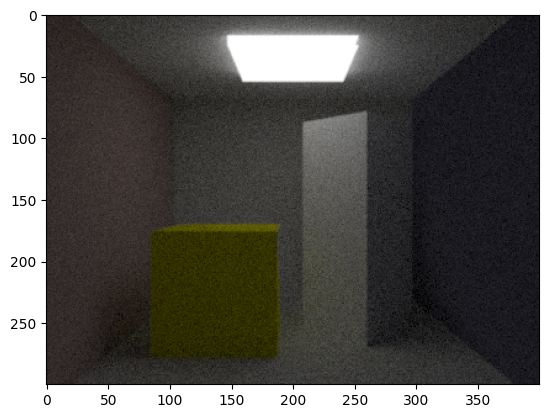

In [441]:
with open('29691_400x300_120.npy', 'rb') as f:
    img = np.load(f)
with open('569423_400x300_120.npy', 'rb') as f:
    img += np.load(f)
with open('124129_400x300_27.npy', 'rb') as f:
    img += np.load(f)
with open('985042_400x300_14.npy', 'rb') as f:
    img += np.load(f)
plt.imshow(np.power(img/np.max(img), 0.45))

# Weitere Experimente
In den Folgenden Abschnitten werden einige weitere Fähigkeiten des Raytracers ausprobiert die im Finalen Bild nicht oder nicht besonders ausgeprägt zum Einsatz kamen.
## Spiegelnde Oberflächen
Im Folgenden wird eine Szene mit einem spielgelnden Material getestet.

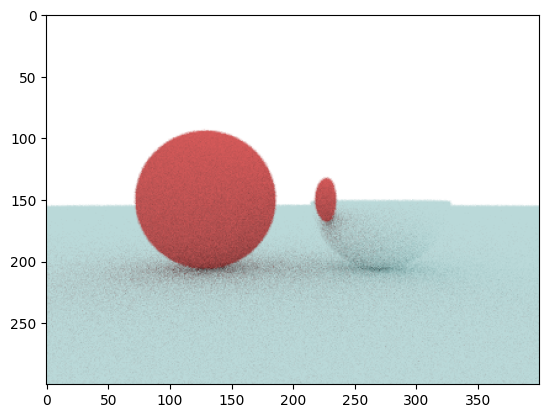

In [47]:
pixeldensity = 100

camera = Camera(position = np.array([0,0,-50]),
                direction = np.array([0,0,1]),
                up = np.array([0,1,0]),
                fov = 60,
                size_x = 4 * pixeldensity,
                size_y = 3 * pixeldensity,
                bounces = 10,
                iterations = 20,
                sky = np.array([1,1,1]))


scene = Scene()

mirror = Opaque(np.array([1,1,1]), np.array([1,1,1]), 1, 1000)

red = Opaque(np.array([0.7,0.1,0.1]), np.array([0.7,0.5,0.5]), 0, 0.1)
gray = Opaque(np.array([0.5,0.7,0.7]), np.array([0,0,0]), 0, 0.1)

mirror_sphere = Sphere(np.array([10,0,0]),8,mirror)
scene.add(mirror_sphere)

ground = Sphere(np.array([0,-100008,0]),100000,gray)
scene.add(ground)

sphere = Sphere(np.array([-10,0,0]),8,red)
scene.add(sphere)

plt.imshow(camera.render(scene))

## Metallische Oberflächen
Im Folgenden wird eine Szene mit einem metallischen Material getestet.

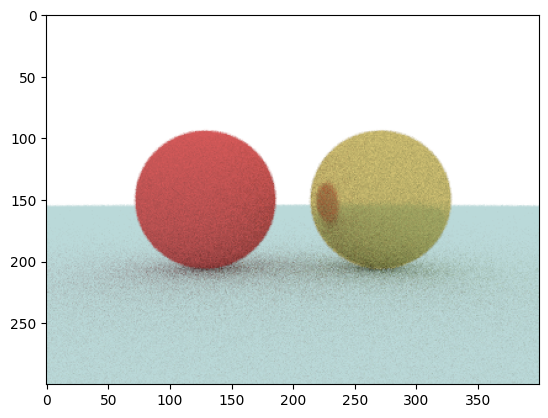

In [450]:
pixeldensity = 100

camera = Camera(position = np.array([0,0,-50]),
                direction = np.array([0,0,1]),
                up = np.array([0,1,0]),
                fov = 60,
                size_x = 4 * pixeldensity,
                size_y = 3 * pixeldensity,
                bounces = 10,
                iterations = 20,
                sky = np.array([1,1,1]))


scene = Scene()

metal = Opaque(np.array([0.83,0.69,0.22])/2, np.array([0.83,0.69,0.22]), 0.4, 5)

red = Opaque(np.array([0.7,0.1,0.1]), np.array([0.7,0.5,0.5]), 0, 0.1)
gray = Opaque(np.array([0.5,0.7,0.7]), np.array([0,0,0]), 0, 0.1)

metal_sphere = Sphere(np.array([10,0,0]),8,metal)
scene.add(metal_sphere)

ground = Sphere(np.array([0,-100008,0]),100000,gray)
scene.add(ground)

sphere = Sphere(np.array([-10,0,0]),8,red)
scene.add(sphere)

plt.imshow(camera.render(scene))

## Testszene

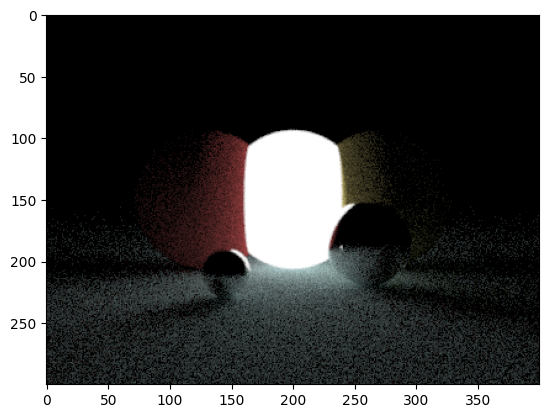

In [453]:
pixeldensity = 100

camera = Camera(position = np.array([0,0,-50]),
                direction = np.array([0,0,1]),
                up = np.array([0,1,0]),
                fov = 60,
                size_x = 4 * pixeldensity,
                size_y = 3 * pixeldensity,
                bounces = 10,
                iterations = 50,
                sky = np.array([0,0,0]))


scene = Scene()

light = Emissive(np.array([1,1,1]))

mirror = Opaque(np.array([1,1,1]), np.array([1,1,1]), 1, 1000)

metal = Opaque(np.array([0.83,0.69,0.22])/2, np.array([0.83,0.69,0.22]), 0.4, 5)

red = Opaque(np.array([0.7,0.1,0.1]), np.array([0.7,0.5,0.5]), 0, 0.1)
gray = Opaque(np.array([0.5,0.7,0.7]), np.array([0,0,0]), 0, 0.1)

metal_sphere = Sphere(np.array([10,0,0]),8,metal)
scene.add(metal_sphere)

ground = Sphere(np.array([0,-100008,0]),100000,gray)
scene.add(ground)

sphere = Sphere(np.array([-10,0,0]),8,red)
scene.add(sphere)

sphere = Sphere(np.array([0,0,0]),8,light)
scene.add(sphere)

sphere = Sphere(np.array([7,-4,-10]),4,mirror)
scene.add(sphere)

sphere = Sphere(np.array([-5.5,-6,-15]),2,mirror)
scene.add(sphere)

plt.imshow(camera.render(scene))